# Implementing a Multi-layer Artificial Neural Network from Scratch


### Multilayer Perceptron (MLP)

1. Starting at the input layer, we forward propagate the patterns of the training data through the
network to generate an output.

2. Based on the network’s output, we calculate the loss that we want to minimize using a loss
function that we will describe later.   

3. We backpropagate the loss, find its derivative with respect to each weight and bias unit in the
network, and update the model.

<br>
MLP is a typical example of a feedforward artificial NN. The term feedforward refers to the fact that
each layer serves as the input to the next layer without loops, in contrast to recurrent NNs

## Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [ ]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


The n×m dimensional
X array consists of 70,000 images with 784 pixels each, and the y array stores the corresponding 70,000
class labels

(originally 0 to 255)
Normalize to [-1, 1] range:

In [ ]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

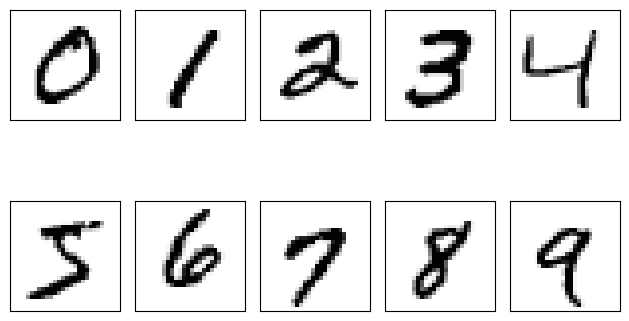

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Visualize 25 different versions of "7":

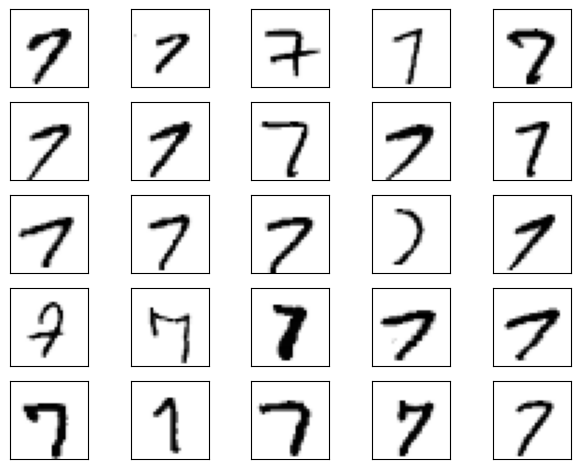

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
digit = 7
for i in range(25):
    img = X[y == digit][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Split into training, validation, and test set:

We will split
the dataset such that 55,000 images are used for training, 5,000 images for validation, and 10,000
images for testing

In [ ]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

<br>
<br>

## Implementing a multi-layer perceptron

In [ ]:
import numpy as np

In [ ]:
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    array = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        array[i, val] = 1

    return array


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        rng = np.random.RandomState(random_seed)

        # hidden layer
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output layer
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

In [ ]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

## Coding the neural network training loop

Now that we have implemented the NeuralNetMLP class and initiated a
model, the next step is to train the model.

We will tackle this in multiple steps.
 - First, we will define
some helper functions for data loading.
 - Second, we will embed these functions into the training loop
that iterates over the dataset in multiple epochs.

The first function we are going to define is a mini-batch generator, which takes in our dataset and divides
it into mini-batches of a desired size for stochastic gradient descent training.

In [ ]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]


# let’s confirm that the mini-batch generator works as intended and produces mini-batches of the desired size
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [ ]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.4%


The model.forward() returns the hidden and output layer activations.
So we have 10 output nodes (one corresponding to each unique class label).

Hence,
when computing the MSE, we first converted the class labels into one-hot encoded class labels in
the mse_loss() function.

- --
Using the previous code, we can compute the performance on the whole training set if
we provide y_train as input to targets and the predicted labels from feeding the model with X_train.

However, in practice, our computer memory is usually a limiting factor for how much data the model
can ingest in one forward pass (due to the large matrix multiplications).

Hence, we are defining our MSE and accuracy computation based on our previous mini-batch generator.

So we will compute the MSE and accuracy incrementally by iterating over the dataset one mini-batch at a
time to be more memory-efficient.

In [ ]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [ ]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.4%


Let’s now get to the main part and implement the code to train our model

- On a high level, the train() function iterates over multiple epochs, and in each epoch, it used the previously defined minibatch_generator() function to iterate over the whole training set in mini-batches
for stochastic gradient descent training.

- Inside the mini-batch generator for loop, we obtain the outputs from the model, a_h and a_out, via its .forward() method.

- Then, we compute the loss gradients
via the model’s .backward() method. Using the loss
gradients, we update the weights by adding the negative gradient multiplied by the learning rate.

In [ ]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [ ]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 76.15% | Valid Acc: 75.98%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 85.45% | Valid Acc: 85.04%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 87.82% | Valid Acc: 87.60%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 89.36% | Valid Acc: 89.28%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.21% | Valid Acc: 90.04%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.67% | Valid Acc: 90.54%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.12% | Valid Acc: 90.82%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.43% | Valid Acc: 91.26%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 91.84% | Valid Acc: 91.50%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.04% | Valid Acc: 91.84%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.30% | Valid Acc: 92.08%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.51% | Valid Acc: 92.24%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.65% | Valid Acc: 92.30%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.80

The reason why we print all this output is that, in NN training, it is really useful to compare training
and validation accuracy. This helps us judge whether the network model performs well, given the
architecture and hyperparameters.

In general, training (deep) NNs is relatively expensive compared with the other models. Thus, we want to stop it early in certain circumstances and start over with different hyperparameter settings.

## Evaluating the neural network performance

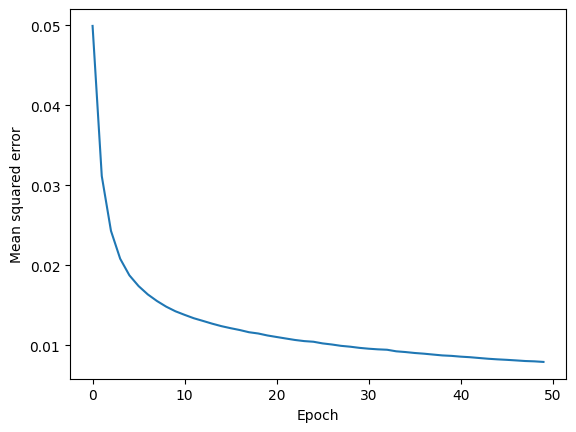

In [ ]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

- As we can see, the loss decreased substantially during the first 10 epochs and seems to slowly converge
in the last 10 epochs.
- However, the small slope between epoch 40 and epoch 50 indicates that the loss
would further decrease with training over additional epochs.

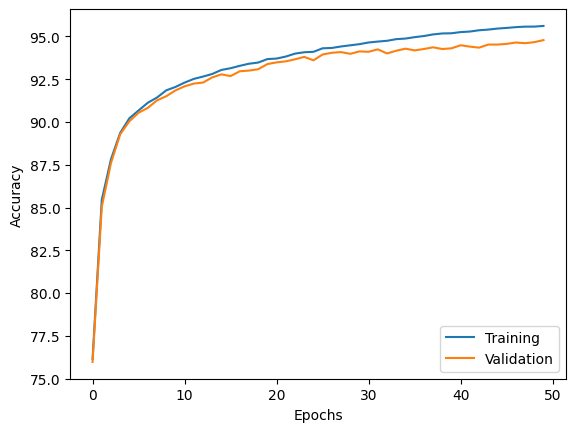

In [ ]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

The plot reveals that the gap between training and validation accuracy increases as we train for more
epochs.

At approximately the 25th epoch, the training and validation accuracy values are almost equal,
and then, the network starts to slightly overfit the training data.

In [ ]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.54%


Plot failure cases:

In [ ]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

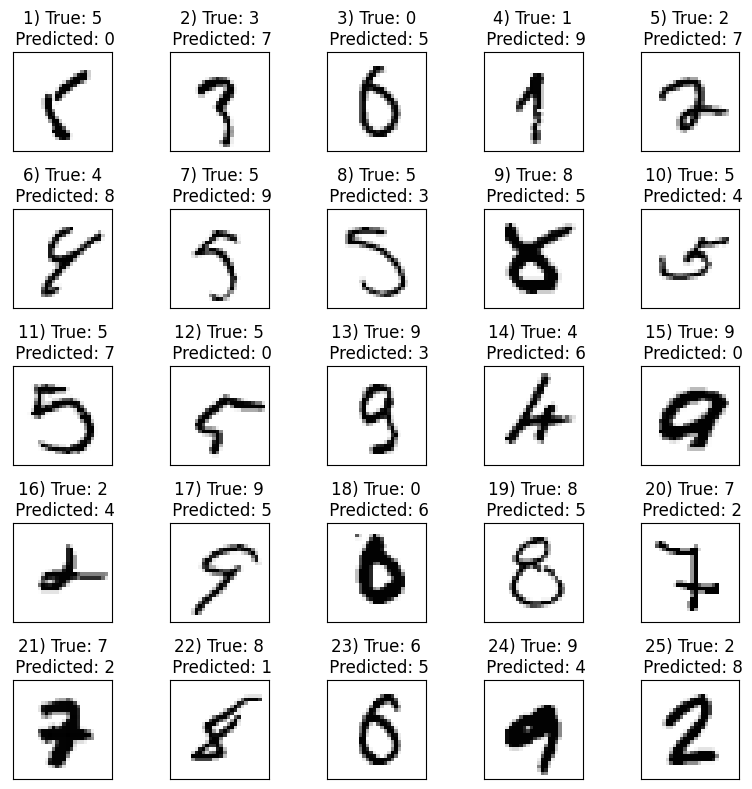

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

- As we can see among others, the network finds 7s challenging when they include a
horizontal line as in examples 19 and 20.

- Looking back at an earlier figure where we
plotted different training examples of the number 7, we can hypothesize that the handwritten digit 7
with a horizontal line is underrepresented in our dataset and is often misclassified.

<br>
<br>

# Convergence in neural networks

- In MLP, we did not use regular gradient descent but instead used mini-batch
learning to train our NN for the handwritten digit classification earlier.  

- In online learning, we compute the gradient based
on a single training example (k=1) at a time to perform the weight update. Although this is a stochastic approach, it often leads to very accurate solutions with a much faster convergence than regular gradient descent.

- Mini-batch learning is a special form of SGD where we compute the gradient based on
a subset k of the n training examples with (1 < k < n).

- Mini-batch learning has an advantage over online
learning in that we can make use of our vectorized implementations to improve computational efficiency. However, we can update the weights much faster than in regular gradient descent.

- Intuitively, we can think of mini-batch learning as predicting the voter turnout of a presidential election from a poll by asking only a representative subset of the population rather than asking the entire population (which would be equal to running the actual election).

In multilayer NNs, we typically have hundreds, thousands, or even
billions of weights that we need to optimize. Unfortunately, the output function has a rough surface,
and the optimization algorithm can easily become trapped in local minima.

By increasing the learning rate, we can more readily escape such local
minima. On the other hand, we also increase the chance of overshooting the global optimum if the
learning rate is too large.

- --